#### Import Depenedancies 

In [ ]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import random
import instructor

from utils.utils import get_tool_descriptions, format_ai_message


### Single Node Graph

In [2]:
class State(BaseModel): 
    """State for the single node graph"""
    message: str
    answer: str = ""
    vibe: str 

In [3]:
def append_vibes_to_query(state:State) -> dict():
    return {
    "answer": f"{state.message}{state.vibe}"
    }

In [4]:
workflow = StateGraph(State)
workflow.add_node("append_vibes_to_query",append_vibes_to_query)

workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibes_to_query",END)

graph = workflow.compile()

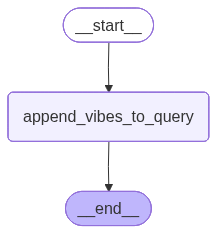

In [5]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
initial_state = {
    "message": "Give me some vibes!",
    "vibe": "I'm feeling like a awesome today!"
}

In [7]:
result = graph.invoke(initial_state)


In [8]:
result

{'message': 'Give me some vibes!',
 'answer': "Give me some vibes!I'm feeling like a awesome today!",
 'vibe': "I'm feeling like a awesome today!"}

#### Conditional Graph


In [9]:
class State(BaseModel):
    message: str
    answer: str = ""

In [10]:
def append_vibes_to_query(state: State) -> dict:

    return {
        "answer": "I am here to add some vibes:"
        }

In [11]:
def router(state: State) -> Literal["append_vibe_1", "append_vibe_2", "append_vibe_3"]:

    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe_3"]

    vibe_path = random.choice(vibes)

    return vibe_path

In [12]:
def append_vibe_1(state: State) -> dict:

    vibe = "I'm feeling like a badass today!"

    return {
        "answer": f"{state.answer} {state.message} {vibe}"
        }

def append_vibe_2(state: State) -> dict:

    vibe = "I'm feeling like a boss today!"

    return {
        "answer": f"{state.answer} {state.message} {vibe}"
        }

def append_vibe_3(state: State) -> dict:

    vibe = "I'm feeling like a legend today!"

    return {
        "answer": f"{state.answer} {state.message} {vibe}"
        }

In [13]:
workflow = StateGraph(State)
workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2",append_vibe_2)
workflow.add_node("append_vibe_3",append_vibe_3)

#create conditional edge

workflow.add_edge(START,"append_vibes_to_query")
workflow.add_conditional_edges(
    "append_vibes_to_query",
    router
)

workflow.add_edge("append_vibe_1",END)
workflow.add_edge("append_vibe_2",END)
workflow.add_edge("append_vibe_3",END)

graph = workflow.compile()




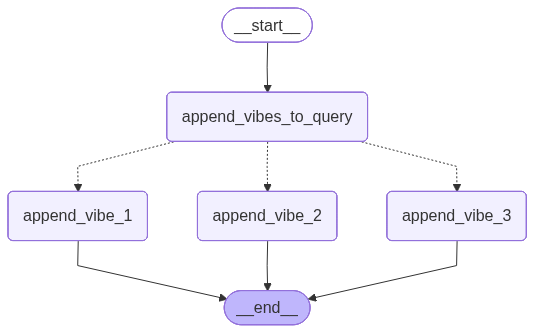

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initial_state = {"message":"Give me some vibes!"}


In [16]:
result = graph.invoke(initial_state)

In [17]:
result

{'message': 'Give me some vibes!',
 'answer': "I am here to add some vibes: Give me some vibes! I'm feeling like a badass today!"}

#### Agent Graph

In [ ]:
def append_vibes(query: str, vibe: str) -> str:
    """Takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """
    
    return f"{query} {vibe}"

In [19]:
# get_tool_descriptions([append_vibes])


In [20]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
# messages: The conversation history (all user/assistant messages)
# Annotated[List[Any], add]: The add operator means when a node returns messages, they get appended to the existing list (not replaced)
# Without add, each update would overwrite the previous messages
# With add, you build up the conversation history over time
    messages: Annotated[List[Any], add] = [] 
    message: str = ""
    iteration: int = 0 # Tracks how many times the graph has looped/iterated Useful for preventing infinite loops or tracking progress
    answer: str =""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []


In [21]:

def agent_node(state: State) -> dict: 
     # LLM looks at conversation history + available tools
    # Decides: call a tool OR give final answer
    # Returns updated state with tool_calls(structured JSON) or answer(plain text)
    prompt_template = """ You are an assisttant that is generating vibes for a user.
    You will be given a selection of tools that you can use to add vibes to a user's query.
   
    <Avaialable tool> 
    {{available_tools | tojson }}
    </Available tools>

    When you need to use a tool, format your response as: 

    <tool_call>
    {"name": "tool_name", "arguments": {...}}
    </tool_call>

    Instructions:
    - You need to use the tools to add vibes to the user's query.
    - Add a random vibe to the user's query.
    """

    template = Template(prompt_template)

    prompt = template.render(
        available_tools=state.available_tools
    )
    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role":"system", "content":prompt}, {"role":"user","content":state.message}],
        temperature=0.5
    )

    ai_message = format_ai_message(response)

    return {

        "messages" : [ai_message],
        "tool_calls": response.tool_calls 
    }

    ## at the end we will have list of messages in our state that will be utilised for our graph execution

    

In [22]:
def tool_router(state:State) -> str: 
    """Decide whether to continue or end"""

    # Inspects the state after agent_node runs
    # Routes to next step based on agent's decision
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"    

In [23]:
workflow = StateGraph(State)

tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")

## adding conditional routing on an agent_node 
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "tool_node",
        "end": END
    }
)
workflow.add_edge("tool_node", END)

graph = workflow.compile()


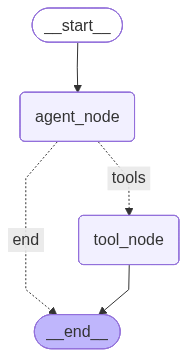

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
#### Invoke the agent graph

In [26]:


initial_state = {
    "message": "Give me some vibes!",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)


In [27]:
result

{'messages': [AIMessage(content='Adding some vibes to your request!', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes! chill and positive', name='append_vibes', tool_call_id='call_0')],
 'message': 'Give me some vibes!',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append the vibe to.'},
     'vibe': {'type': 'string',
      'description': 'The vibe to append to the query.'}}},
   'required': ['query', 'vibe'],
   'returns': {'type': 'string',
    'description': 'A string with the query and vibe appended.'}}],
 'tool_calls': [ToolCall(name='append_vibes', arguments={'query': 'Give me

## Agent Graph with loopback from Tools
- we want our agent to call back tools multiple times

In [55]:
def append_vibes(query: str, vibe: str) -> str:
    """Takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """
    
    vibes = [
            "awesome and energetic",
            "chill and positive", 
            "legendary and bold",
            "fierce and unstoppable",
            "zen and peaceful"
        ]
    random_vibe = random.choice(vibes)
    return f"{query} {random_vibe}"

In [56]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
# messages: The conversation history (all user/assistant messages)
# Annotated[List[Any], add]: The add operator means when a node returns messages, they get appended to the existing list (not replaced)
# Without add, each update would overwrite the previous messages
# With add, you build up the conversation history over time
    messages: Annotated[List[Any], add] = [] 
    message: str = ""
    iteration: int = 0 # Tracks how many times the graph has looped/iterated Useful for preventing infinite loops or tracking progress
    answer: str =""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [57]:

from email import message


def agent_node(state: State) -> dict: 
     # LLM looks at conversation history + available tools
    # Decides: call a tool OR give final answer
    # Returns updated state with tool_calls(structured JSON) or answer(plain text)
    prompt_template = """ You are an assisttant that is generating vibes for a user.
    You will be given a selection of tools that you can use to add vibes to a user's query.
   
    <Avaialable tool> 
    {{available_tools | tojson }}
    </Available tools>

    When you need to use a tool, format your response as: 

    <tool_call>
    {"name": "tool_name", "arguments": {...}}
    </tool_call>

    Instructions:
    - You need to use the tools to add vibes to the user's query.
    - Add a random vibe to the user's query.
    - You must return a tool call in the first iteration
    """

    template = Template(prompt_template)

    prompt = template.render(
        available_tools=state.available_tools
    )

    messages = state.messages

    conversation = convert_to_openai_messages(messages)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role":"system", "content":prompt}, *conversation],
        temperature=0.5
    )

    ai_message = format_ai_message(response)

    return {

        "messages" : [ai_message],
        "tool_calls": response.tool_calls,
        "iteration" : state.iteration + 1,
        "answer" : response.answer
    }


    

In [58]:
def tool_router(state:State) -> str: 
    """Decide whether to continue or end"""

    # Inspects the state after agent_node runs
    # Routes to next step based on agent's decision
    if state.iteration > 1:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"    
        

In [59]:
workflow = StateGraph(State)
tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node",tool_node)


workflow.add_edge(START,"agent_node")
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    { "tools": "tool_node",
    "end": END
    }
)

workflow.add_edge("tool_node", "agent_node")
graph = workflow.compile()

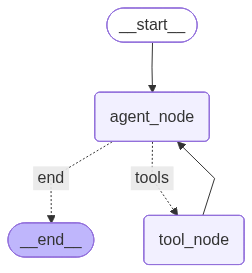

In [60]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
initial_state = {
    "messages": [{"role": "user", "content": "Give me some vibes!"}],
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)


In [64]:
result


{'messages': [{'role': 'user', 'content': 'Give me some vibes!'},
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes! awesome and energetic', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content='Give me some vibes! awesome and energetic', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'awesome and energetic'}, 'id': 'call_0', 'type': 'tool_call'}])],
 'iteration': 2,
 'answer': 'Give me some vibes! awesome and energetic',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to ap